In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score

from sklearn.metrics import precision_recall_fscore_support


import pickle

import json

In [2]:
from json import JSONEncoder
import json
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [3]:

def data_preprocess(data):
  '''We input the data with the linguistic features
  And it returns the data with the polarity columns in 0 for fake and 1 for true
  as well as the outcomes
  '''

  if data["Polarity"][0] != 0 or 1:
    data["Polarity"] = data["Polarity"].replace("Fake", 0)
    data["Polarity"] = data["Polarity"].replace("TRUE", 1)
    data["Polarity"] = data["Polarity"].replace("True", 1)

  outcomes = ["Fake","Real"]
  
  return data, outcomes

def test_train(data, features):

  '''We input the data with the features and a list of the features we want to pass to the models.
  it returns the data split in test/train
  '''

  feature_cols = features
  data = data[feature_cols + ["Polarity"]].dropna()

  X = data[feature_cols]
  y = data["Polarity"] #outcomes 0 or 1


  print("Info: {} features were passed at the fit step\n:".format(X.shape[1]))
  for feature in feature_cols:
    print(feature)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=16) #stratify so that the proportion of the train data is the same for fake and true

  return X, y, X_train, X_test, y_train, y_test, features

def class_report(y_test, y_pred):

  outcomes = ["Fake","Real"]

  scores = classification_report(y_test, y_pred, target_names=outcomes)

  print(scores)

  return scores

def compare_models_cross_val(model, X, y):
  
  '''for each model, it calculates the cross validation accuracy for each iteration
  as well as the mean cross validation score on the given data

  '''

  print("CROSS VALIDATION\n")

  model_name = str(model)[:-2]

  if model_name == "SVC(kernel=\'linear":

    model_name = "SVC"


  # for model in models:
  cv_score = cross_val_score(model, X, y, cv = 5)
  print("Cross validation accuracy {} for each of the 5 iterations:".format(model_name))
  for score in cv_score:
    print(round(score*100, 2), "%")

  mean_accuracy = sum(cv_score)/len(cv_score)

  print("\nCross validation mean accuracy for {}:".format(model_name), round(mean_accuracy*100, 2),"%")
  print("\n-------------------------------------------------------------------------\n")

  return cv_score, mean_accuracy

def conf_matrix(model_name, features, y_pred, y_test, cmap="magma"):

  '''This function takes the predicted and test labels, generates the confusion matrix
  and displays it
  '''

  confussion_matrix = confusion_matrix(y_pred, y_test)

  outcomes = ["Fake","Real"]
  ticks = np.arange(len(outcomes))

  fig, ax = plt.subplots()
  plt.xticks(ticks, outcomes)
  plt.yticks(ticks, outcomes)
  sns.heatmap(pd.DataFrame(confussion_matrix), annot=True, cmap=cmap, fmt="g", xticklabels=outcomes, yticklabels=outcomes)
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  
  plt.title("{} Confusion Matrix: All available features".format(model_name), y = 1.1)


  plt.ylabel("Actual label")
  plt.xlabel("Predicted label")

  return confussion_matrix

def compare_models_train_test_split(models, X, y, X_train, y_train, X_test, y_test, features):

  '''this fx trains the data on the four types of models,
  generates a report with the overall accuracy of the model, the cross validation evaluation
  and prints the confussion matrix of each model on the particular test_train split.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the cross-validation evaluation and the confusion matrix
  '''

  model_list_dicts =[]

  for model in models:
    
    model_name = str(model)[:-2]

    if model_name == "SVC(kernel=\'linear":

      model_name = "SVC"
    
    model_dict = {}
    
    model_dict["name"] = "All_features__" + model_name
    
    model_dict["features"] = features

    model_dict["model"] = model_name
    
    print("\n",model_name, "\n", "\n")
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    model_dict["accuracy"] = accuracy
    
    print("OVERALL ACCURACY", model_name, ":", round(accuracy*100, 2),"%""\n")
    
    scores = class_report(y_test, y_pred)
    
    P_R_F1_true = precision_recall_fscore_support(y_test, y_pred, labels=[1])
    precision_true, recall_true , f1_score_true  = P_R_F1_true[0], P_R_F1_true[1] ,  P_R_F1_true[2]
    
    P_R_F1_false = precision_recall_fscore_support(y_test, y_pred, labels=[0])
    precision_false, recall_false, f1_score_false = P_R_F1_false[0], P_R_F1_false[1], P_R_F1_false[2]
    
    model_dict["precision_true"], model_dict["recall_true"], model_dict["f1_score_true"] = precision_true, recall_true, f1_score_true
    model_dict["precision_false"], model_dict["recall_false"], model_dict["f1_score_false"] = precision_false, recall_false, f1_score_false

    cv_score, mean_accuracy = compare_models_cross_val(model, X, y)
    
    model_dict["cv_scores"] = cv_score

    model_dict["mean_cv_accuracy"] = mean_accuracy
    
    confussion_matrix = conf_matrix(model_name, features, y_pred, y_test, cmap="magma")
    
    model_dict["confussion_matrix"] = confussion_matrix

    model_list_dicts.append(model_dict)
    
    pickle.dump(model, open(r"C:\Users\alber\Desktop\Make Believe Diciembre\Models\{}.sav".format(model_dict["name"]), 'wb'))
    
      
    with open(r"C:\Users\alber\Desktop\Make Believe Diciembre\Models\Info Dictionaries\{}.json".format(model_dict["name"]), "w") as f:
      json.dump(model_dict, f, cls=NumpyArrayEncoder)
  
  
  return model_list_dicts

def magic(data, features):

  '''this function takes all the previous functions and integrates them into a single function to run the data processing, training and testing in all the models.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the crossvalidation evaluation and the confusion matrix

  '''

  data, outcomes = data_preprocess(data) # data in the correct format for the y outcomes

  X, y, X_train, X_test, y_train, y_test, features = test_train(data, features) # data split for all the models with the desired features

  model_list_dicts = compare_models_train_test_split(models, X, y, X_train, y_train, X_test, y_test, features) # for each model it will compute

  return model_list_dicts


In [4]:
all_fts = pd.read_csv(r"C:\Users\alber\Desktop\Make Believe Diciembre\all_ling_features.csv")

In [5]:
all_fts = all_fts.drop(labels="id", axis=1)
print(all_fts.shape)
all_fts

(480, 63)


,DESPC,DESSC,DESWC,DESPL,DESPLd,DESPLw,DESSL,DESSLd,DESWLsy,DESWLsyd,...,WORD_PROPERTY_WRDHYPn,WORD_PROPERTY_WRDHYPv,WORD_PROPERTY_WRDHYPnv,WORD_PROPERTY_AOA,WORD_PROPERTY_AOA_MAX,WORD_PROPERTY_CONCRETENESS,WORD_PROPERTY_PREVALENCE,WORD_PROPERTY_PREVALENCE_MIN,WORD_SET_INCIDENCE_C4_COMMON_WORDS,Polarity
0,0.666667,0.000000,0.187192,0.000000,0.000000,0.103911,0.903743,0.000000,1.000000,1.000000,...,0.244583,0.283489,0.388215,0.687937,0.396186,0.434696,0.637852,0.637852,0.685198,Fake
1,0.333333,0.272727,0.325123,0.125000,0.272727,0.157542,0.331016,0.509944,0.109532,0.205917,...,0.267995,0.338908,0.076927,0.051748,0.309322,0.676325,0.646687,0.646687,0.252618,Fake
2,0.333333,0.363636,0.354680,0.166667,0.363636,0.177654,0.254011,0.442546,0.199330,0.239295,...,0.471208,0.183434,0.469044,0.238065,0.297608,0.756879,0.615946,0.615946,0.546360,Fake
3,0.333333,0.272727,0.394089,0.125000,0.272727,0.197765,0.398396,0.388716,0.191279,0.211500,...,0.467174,0.177570,0.512643,0.110266,0.147246,0.899076,0.361177,0.361177,0.367094,Fake
4,0.333333,0.454545,0.379310,0.208333,0.454545,0.177654,0.195569,0.227758,0.139367,0.150569,...,0.622575,0.380685,0.427168,0.267677,0.617585,0.241192,0.460505,0.460505,0.550734,Fake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.000000,0.176471,0.273810,0.207547,0.176471,0.389978,0.282569,0.164698,0.237409,0.163831,...,0.506349,0.419364,0.515360,0.293080,0.263963,0.566979,0.568377,0.568377,0.623859,True
476,0.857143,0.117647,0.250000,0.015094,0.037203,0.091503,0.380734,0.384460,0.002353,0.000000,...,0.455246,0.066528,0.234069,0.097540,0.281215,0.426243,0.741069,0.741069,0.387643,True
477,0.285714,0.000000,0.103175,0.000000,0.048029,0.129751,0.642202,0.000000,0.353339,0.214612,...,0.592211,0.281358,0.521021,0.352350,0.582677,0.812008,0.687372,0.687372,0.242686,True
478,0.000000,0.470588,0.519841,0.490566,0.352941,0.578794,0.144954,0.189306,0.194554,0.167312,...,0.492107,0.000000,0.305626,0.095886,0.388076,0.464801,0.698401,0.698401,0.143949,True


In [6]:
nan_dict = {}
for col in all_fts:
    nan_dict[col] = all_fts[col].isna().sum()
print(nan_dict)


{'DESPC': 0, 'DESSC': 0, 'DESWC': 0, 'DESPL': 0, 'DESPLd': 30, 'DESPLw': 0, 'DESSL': 0, 'DESSLd': 0, 'DESWLsy': 0, 'DESWLsyd': 0, 'DESWLlt': 0, 'DESWLltd': 0, 'LDTTRc': 0, 'LDTTRa': 0, 'LDMTLD': 0, 'LDHDD': 0, 'SYNLE': 0, 'SYNNP': 0, 'SYNMEDpos': 0, 'SYNMEDwrd': 0, 'SYNMEDlem': 0, 'SYNSTRUTa': 0, 'SYNSTRUTt': 480, 'RDFRE': 0, 'READFKGL': 0, 'TOKEN_ATTRIBUTE_RATIO_ALHPA': 0, 'TOKEN_ATTRIBUTE_RATIO_DIGIT': 0, 'TOKEN_ATTRIBUTE_RATIO_PUNCT': 0, 'TOKEN_ATTRIBUTE_RATIO_URL': 0, 'TOKEN_ATTRIBUTE_RATIO_EMAIL': 480, 'WORD_SET_INCIDENCE_WRDPRP1s': 0, 'WORD_SET_INCIDENCE_WRDPRP1p': 0, 'WORD_SET_INCIDENCE_WRDPRP2': 0, 'WORD_SET_INCIDENCE_WRDPRP3s': 0, 'WORD_SET_INCIDENCE_WRDPRP3p': 0, 'WORD_SET_INCIDENCE_CNCCaus': 0, 'WORD_SET_INCIDENCE_CNCLogic': 0, 'WORD_SET_INCIDENCE_CNCTemp': 0, 'WORD_SET_INCIDENCE_CNCAdd': 0, 'WORD_SET_INCIDENCE_CNCPos': 0, 'WORD_SET_INCIDENCE_CNCNeg': 0, 'WORD_PROPERTY_WRDNOUN': 0, 'WORD_PROPERTY_WRDVERB': 0, 'WORD_PROPERTY_WRDADJ': 0, 'WORD_PROPERTY_WRDADV': 0, 'WORD_PROPER

In [7]:
for k in nan_dict:
    if nan_dict[k] > 0:
        all_fts = all_fts.drop(labels=k, axis = 1)

data = all_fts


In [8]:
features = list(all_fts.columns)[:-1]
print(features)

['DESPC', 'DESSC', 'DESWC', 'DESPL', 'DESPLw', 'DESSL', 'DESSLd', 'DESWLsy', 'DESWLsyd', 'DESWLlt', 'DESWLltd', 'LDTTRc', 'LDTTRa', 'LDMTLD', 'LDHDD', 'SYNLE', 'SYNNP', 'SYNMEDpos', 'SYNMEDwrd', 'SYNMEDlem', 'SYNSTRUTa', 'RDFRE', 'READFKGL', 'TOKEN_ATTRIBUTE_RATIO_ALHPA', 'TOKEN_ATTRIBUTE_RATIO_DIGIT', 'TOKEN_ATTRIBUTE_RATIO_PUNCT', 'TOKEN_ATTRIBUTE_RATIO_URL', 'WORD_SET_INCIDENCE_WRDPRP1s', 'WORD_SET_INCIDENCE_WRDPRP1p', 'WORD_SET_INCIDENCE_WRDPRP2', 'WORD_SET_INCIDENCE_WRDPRP3s', 'WORD_SET_INCIDENCE_WRDPRP3p', 'WORD_SET_INCIDENCE_CNCCaus', 'WORD_SET_INCIDENCE_CNCLogic', 'WORD_SET_INCIDENCE_CNCTemp', 'WORD_SET_INCIDENCE_CNCAdd', 'WORD_SET_INCIDENCE_CNCPos', 'WORD_SET_INCIDENCE_CNCNeg', 'WORD_PROPERTY_WRDNOUN', 'WORD_PROPERTY_WRDVERB', 'WORD_PROPERTY_WRDADJ', 'WORD_PROPERTY_WRDADV', 'WORD_PROPERTY_WRDFRQc', 'WORD_PROPERTY_WRDFRQa', 'WORD_PROPERTY_WRDFRQmc', 'WORD_PROPERTY_WRDFAMc', 'WORD_PROPERTY_WRDCNCc', 'WORD_PROPERTY_WRDIMGc', 'WORD_PROPERTY_WRDMEAc', 'WORD_PROPERTY_WRDPOLc', 'WORD

In [9]:
models = [LogisticRegression(), SVC(kernel ="linear"), KNeighborsClassifier(), RandomForestClassifier()]

Info: 59 features were passed at the fit step
:
DESPC
DESSC
DESWC
DESPL
DESPLw
DESSL
DESSLd
DESWLsy
DESWLsyd
DESWLlt
DESWLltd
LDTTRc
LDTTRa
LDMTLD
LDHDD
SYNLE
SYNNP
SYNMEDpos
SYNMEDwrd
SYNMEDlem
SYNSTRUTa
RDFRE
READFKGL
TOKEN_ATTRIBUTE_RATIO_ALHPA
TOKEN_ATTRIBUTE_RATIO_DIGIT
TOKEN_ATTRIBUTE_RATIO_PUNCT
TOKEN_ATTRIBUTE_RATIO_URL
WORD_SET_INCIDENCE_WRDPRP1s
WORD_SET_INCIDENCE_WRDPRP1p
WORD_SET_INCIDENCE_WRDPRP2
WORD_SET_INCIDENCE_WRDPRP3s
WORD_SET_INCIDENCE_WRDPRP3p
WORD_SET_INCIDENCE_CNCCaus
WORD_SET_INCIDENCE_CNCLogic
WORD_SET_INCIDENCE_CNCTemp
WORD_SET_INCIDENCE_CNCAdd
WORD_SET_INCIDENCE_CNCPos
WORD_SET_INCIDENCE_CNCNeg
WORD_PROPERTY_WRDNOUN
WORD_PROPERTY_WRDVERB
WORD_PROPERTY_WRDADJ
WORD_PROPERTY_WRDADV
WORD_PROPERTY_WRDFRQc
WORD_PROPERTY_WRDFRQa
WORD_PROPERTY_WRDFRQmc
WORD_PROPERTY_WRDFAMc
WORD_PROPERTY_WRDCNCc
WORD_PROPERTY_WRDIMGc
WORD_PROPERTY_WRDMEAc
WORD_PROPERTY_WRDPOLc
WORD_PROPERTY_WRDHYPn
WORD_PROPERTY_WRDHYPv
WORD_PROPERTY_WRDHYPnv
WORD_PROPERTY_AOA
WORD_PROPERTY_AOA_MAX
W

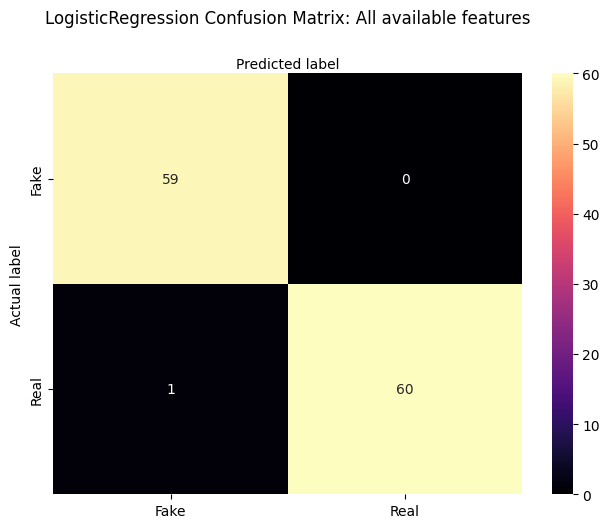

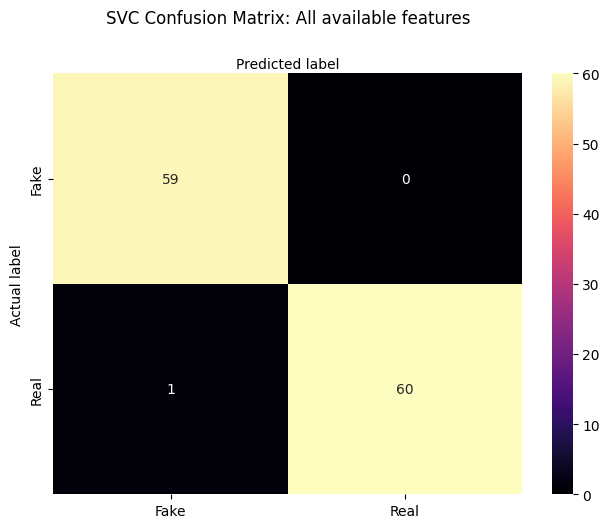

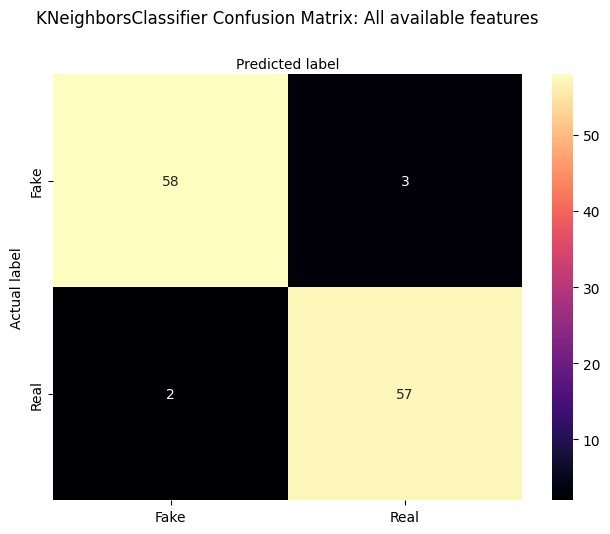

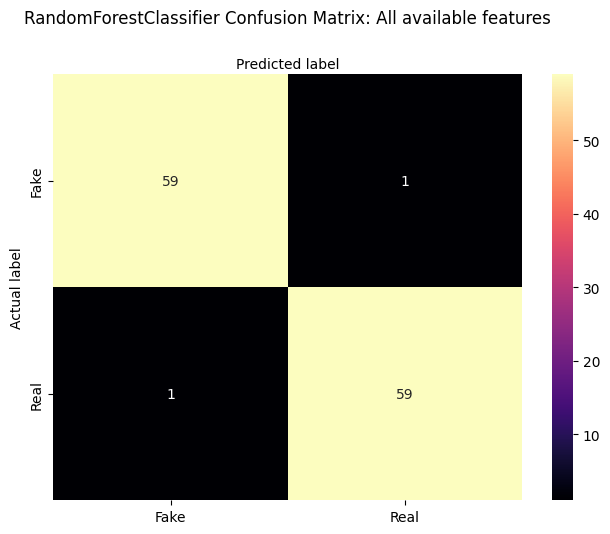

In [10]:
models_all_available_features = magic(data, features)

In [11]:
models_all_available_features

[{'name': 'All_features__LogisticRegression',
  'features': ['DESPC',
   'DESSC',
   'DESWC',
   'DESPL',
   'DESPLw',
   'DESSL',
   'DESSLd',
   'DESWLsy',
   'DESWLsyd',
   'DESWLlt',
   'DESWLltd',
   'LDTTRc',
   'LDTTRa',
   'LDMTLD',
   'LDHDD',
   'SYNLE',
   'SYNNP',
   'SYNMEDpos',
   'SYNMEDwrd',
   'SYNMEDlem',
   'SYNSTRUTa',
   'RDFRE',
   'READFKGL',
   'TOKEN_ATTRIBUTE_RATIO_ALHPA',
   'TOKEN_ATTRIBUTE_RATIO_DIGIT',
   'TOKEN_ATTRIBUTE_RATIO_PUNCT',
   'TOKEN_ATTRIBUTE_RATIO_URL',
   'WORD_SET_INCIDENCE_WRDPRP1s',
   'WORD_SET_INCIDENCE_WRDPRP1p',
   'WORD_SET_INCIDENCE_WRDPRP2',
   'WORD_SET_INCIDENCE_WRDPRP3s',
   'WORD_SET_INCIDENCE_WRDPRP3p',
   'WORD_SET_INCIDENCE_CNCCaus',
   'WORD_SET_INCIDENCE_CNCLogic',
   'WORD_SET_INCIDENCE_CNCTemp',
   'WORD_SET_INCIDENCE_CNCAdd',
   'WORD_SET_INCIDENCE_CNCPos',
   'WORD_SET_INCIDENCE_CNCNeg',
   'WORD_PROPERTY_WRDNOUN',
   'WORD_PROPERTY_WRDVERB',
   'WORD_PROPERTY_WRDADJ',
   'WORD_PROPERTY_WRDADV',
   'WORD_PROPERTY_WRDFR